In [ ]:
# Install all required packages
!python3 -m pip -q install sklearn seaborn tueplots

In [70]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder

from tueplots import axes, bundles, cycler, figsizes, fonts

from PrivDPS import DirichletMechanism, GaussianMechanism, LaplaceMechanism, MLECalculator

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"figure.dpi": 600})
plt.rcParams.update(fonts.jmlr2001_tex(family="serif"))
plt.rcParams.update(bundles.icml2022(family="serif"))
plt.rcParams.update(figsizes.icml2022_full(nrows=1.3))
plt.rcParams.update(cycler.cycler(color=sns.color_palette("bright", 4)))
plt.rcParams.update(axes.lines())
plt.rcParams.update(axes.grid(grid_alpha=0.7))
plt.rcParams.update({'legend.fontsize': 6.5,
                     'legend.handlelength': 2
                    }
                   )
seed = 1
n_repeat = 10
n_bins = 10
eps_list = np.logspace(-3, 1, 10)
model_list = ['Random', 'Non-private', 'Dirichlet', 'Gaussian', 'Laplace']
results = {filename: {model: (np.empty((eps_list.shape[0], n_repeat)),
                              np.empty((eps_list.shape[0], n_repeat)))
                      for model in model_list}
           for filename in os.listdir('data')}


def prepare_data(filename, num_bins, seed):
    data = pd.read_csv(filename)

    y = data.iloc[:, -1]
    X = data.iloc[:, :-1]

    print(filename, y.shape[0],
          y.unique().shape[0],
          X.shape[1],
          (y == y.iloc[0]).mean())

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed)

    # remove cols with only one category
    cat_counts = X_train.nunique()
    X_train = X_train.loc[:, cat_counts!=1]
    X_test = X_test.loc[:, cat_counts!=1]
    # quantile binning while preserving repeated values
    N = X_train.shape[0]
    for col in X_train.columns:
        train_series = X_train[col].copy()
        if train_series.dtype != 'O':
            counts = train_series.value_counts()
            if counts.shape[0] > 30:
                idx = 0
                while idx < counts.shape[0] and counts.iloc[idx] > N/(3**(idx+1)):
                    idx += 1
                if idx < counts.shape[0] and counts.shape[0] - idx > 30:
                    train_remain_idx = train_series.isin(counts.index[idx:])
                    train_subset = train_series[train_remain_idx]
                    train_subset, bins = pd.qcut(train_subset,
                                                 num_bins,
                                                 retbins=True,
                                                 duplicates='drop')
                    X_train.loc[train_remain_idx, col] = train_subset

                    test_series = X_test[col].copy()
                    test_remain_idx = test_series.isin(counts.index[idx:])
                    test_subset = test_series[test_remain_idx]
                    X_test.loc[test_remain_idx, col] = pd.cut(test_subset, bins)

    X_train = X_train.astype(str)
    X_test = X_test.astype(str)
    return X_train, X_test, y_train, y_test

In [2]:
class DPNaiveBayes:
    def __init__(self, sampler, random_state=None):
        """sampler is the probability sampler of a DP mechanism"""
        self.sampler = sampler
        self.log_feature_prob = None
        self.log_class_prob = None
        self.features = None
        self.classes = None
        self.feature_encoder = OneHotEncoder(handle_unknown="ignore")
        self.label_encoder = LabelBinarizer()
        self.random_state = random_state

    def fit(self, X, y):
        X = self.feature_encoder.fit_transform(X)
        y = self.label_encoder.fit_transform(y)
        if y.shape[1] == 1:
            y = np.concatenate((1 - y, y), axis=1)
        feature_count = y.T @ X
        noisy_params = np.zeros_like(feature_count)
        idx = 0
        for feature_list in self.feature_encoder.categories_:
            next_idx = idx+feature_list.shape[0]
            noisy_params[:, idx: next_idx] = self.sampler.sample(feature_count[:, idx: next_idx],
                                                                 seed=self.random_state)
            idx = next_idx
        self.log_feature_prob = np.log(noisy_params)
        noisy_class_params = self.sampler.sample(feature_count.sum(axis=1),
                                                 seed=self.random_state)
        self.log_class_prob = np.log(noisy_class_params)

    def predict_proba(self, X):
        X = self.feature_encoder.transform(X)
        class_logit = (X @ self.log_feature_prob.T) + self.log_class_prob
        class_probs = np.exp(class_logit)
        class_probs /= class_probs.sum(axis=1, keepdims=True)
        return class_probs

    def predict(self, X):
        X = self.feature_encoder.transform(X)
        class_logit = (X @ self.log_feature_prob.T) + self.log_class_prob
        y = self.label_encoder.classes_[class_logit.argmax(axis=1)]
        return y

In [3]:
for filename in os.listdir('data'):
    X_train, X_test, y_train, y_test = prepare_data(os.path.join('data',filename),
                                                    n_bins,
                                                    seed)
    label_encoder = LabelBinarizer()
    label_encoder.fit(y_train)
    y_enc = label_encoder.transform(y_test)
    if y_enc.shape[1] == 1:
        y_enc = np.concatenate((1 - y_enc, y_enc), axis=1)
    num_cats = y_enc.shape[1]
    for i, epsilon in enumerate(eps_list):
        for j in range(n_repeat):
            y_prob = np.random.random_sample(size=(y_enc.shape))
            y_pred = (y_prob == y_prob.max(axis=1, keepdims=True))
            results[filename]['Random'][0][i, j] = -np.log(1/num_cats)
            results[filename]['Random'][1][i, j] = np.mean(np.sum(y_enc*y_pred, axis=1))

data/CreditCard.csv 30000 2 23 0.2212
data/Thyroid.csv 7200 3 21 0.9258333333333333
data/Shopper.csv 12330 2 17 0.8452554744525548
data/Digit.csv 5620 10 64 0.09857651245551602
data/GermanCredit.csv 1000 2 20 0.7
data/Bank.csv 41188 2 20 0.8873458288821987
data/Spam.csv 4601 2 57 0.39404477287546186
data/Adult.csv 48842 2 13 0.7607182343065395


In [4]:
for filename in os.listdir('data'):
    X_train, X_test, y_train, y_test = prepare_data(os.path.join('data',filename),
                                                    n_bins,
                                                    seed)
    for i, epsilon in enumerate(eps_list):
        adjusted_eps = epsilon/(X_train.shape[1]+1) # +1 for privatizing class parameters
        ml = MLECalculator(prior=0.1)
        dm = DirichletMechanism(epsilon=adjusted_eps, lambda_=5, prior=1)
        gm = GaussianMechanism(epsilon=adjusted_eps, lambda_=5)
        lm = LaplaceMechanism(epsilon=adjusted_eps, lambda_=5)
        for name, sampler in zip(model_list[1:],
                                 [ml, dm, gm, lm]):
            for j in range(n_repeat):
                dpnb = DPNaiveBayes(sampler)
                dpnb.fit(X_train, y_train)
                y_enc = dpnb.label_encoder.transform(y_test)
                if y_enc.shape[1] == 1:
                    y_enc = np.concatenate((1 - y_enc, y_enc), axis=1)
                y_prob = dpnb.predict_proba(X_test)
                y_pred = (y_prob == y_prob.max(axis=1, keepdims=True))
                results[filename][name][0][i, j] = -np.sum(y_enc*np.log(y_prob+1e-20))/X_test.shape[0]
                results[filename][name][1][i, j] = np.mean(np.sum(y_enc*y_pred, axis=1))

data/CreditCard.csv 30000 2 23 0.2212
data/Thyroid.csv 7200 3 21 0.9258333333333333
data/Shopper.csv 12330 2 17 0.8452554744525548
data/Digit.csv 5620 10 64 0.09857651245551602
data/GermanCredit.csv 1000 2 20 0.7
data/Bank.csv 41188 2 20 0.8873458288821987
data/Spam.csv 4601 2 57 0.39404477287546186
data/Adult.csv 48842 2 13 0.7607182343065395


In [73]:
import pickle

with open('naive_bayes_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('naive_bayes_results.pickle', 'rb') as handle:
#    results = pickle.load(handle)

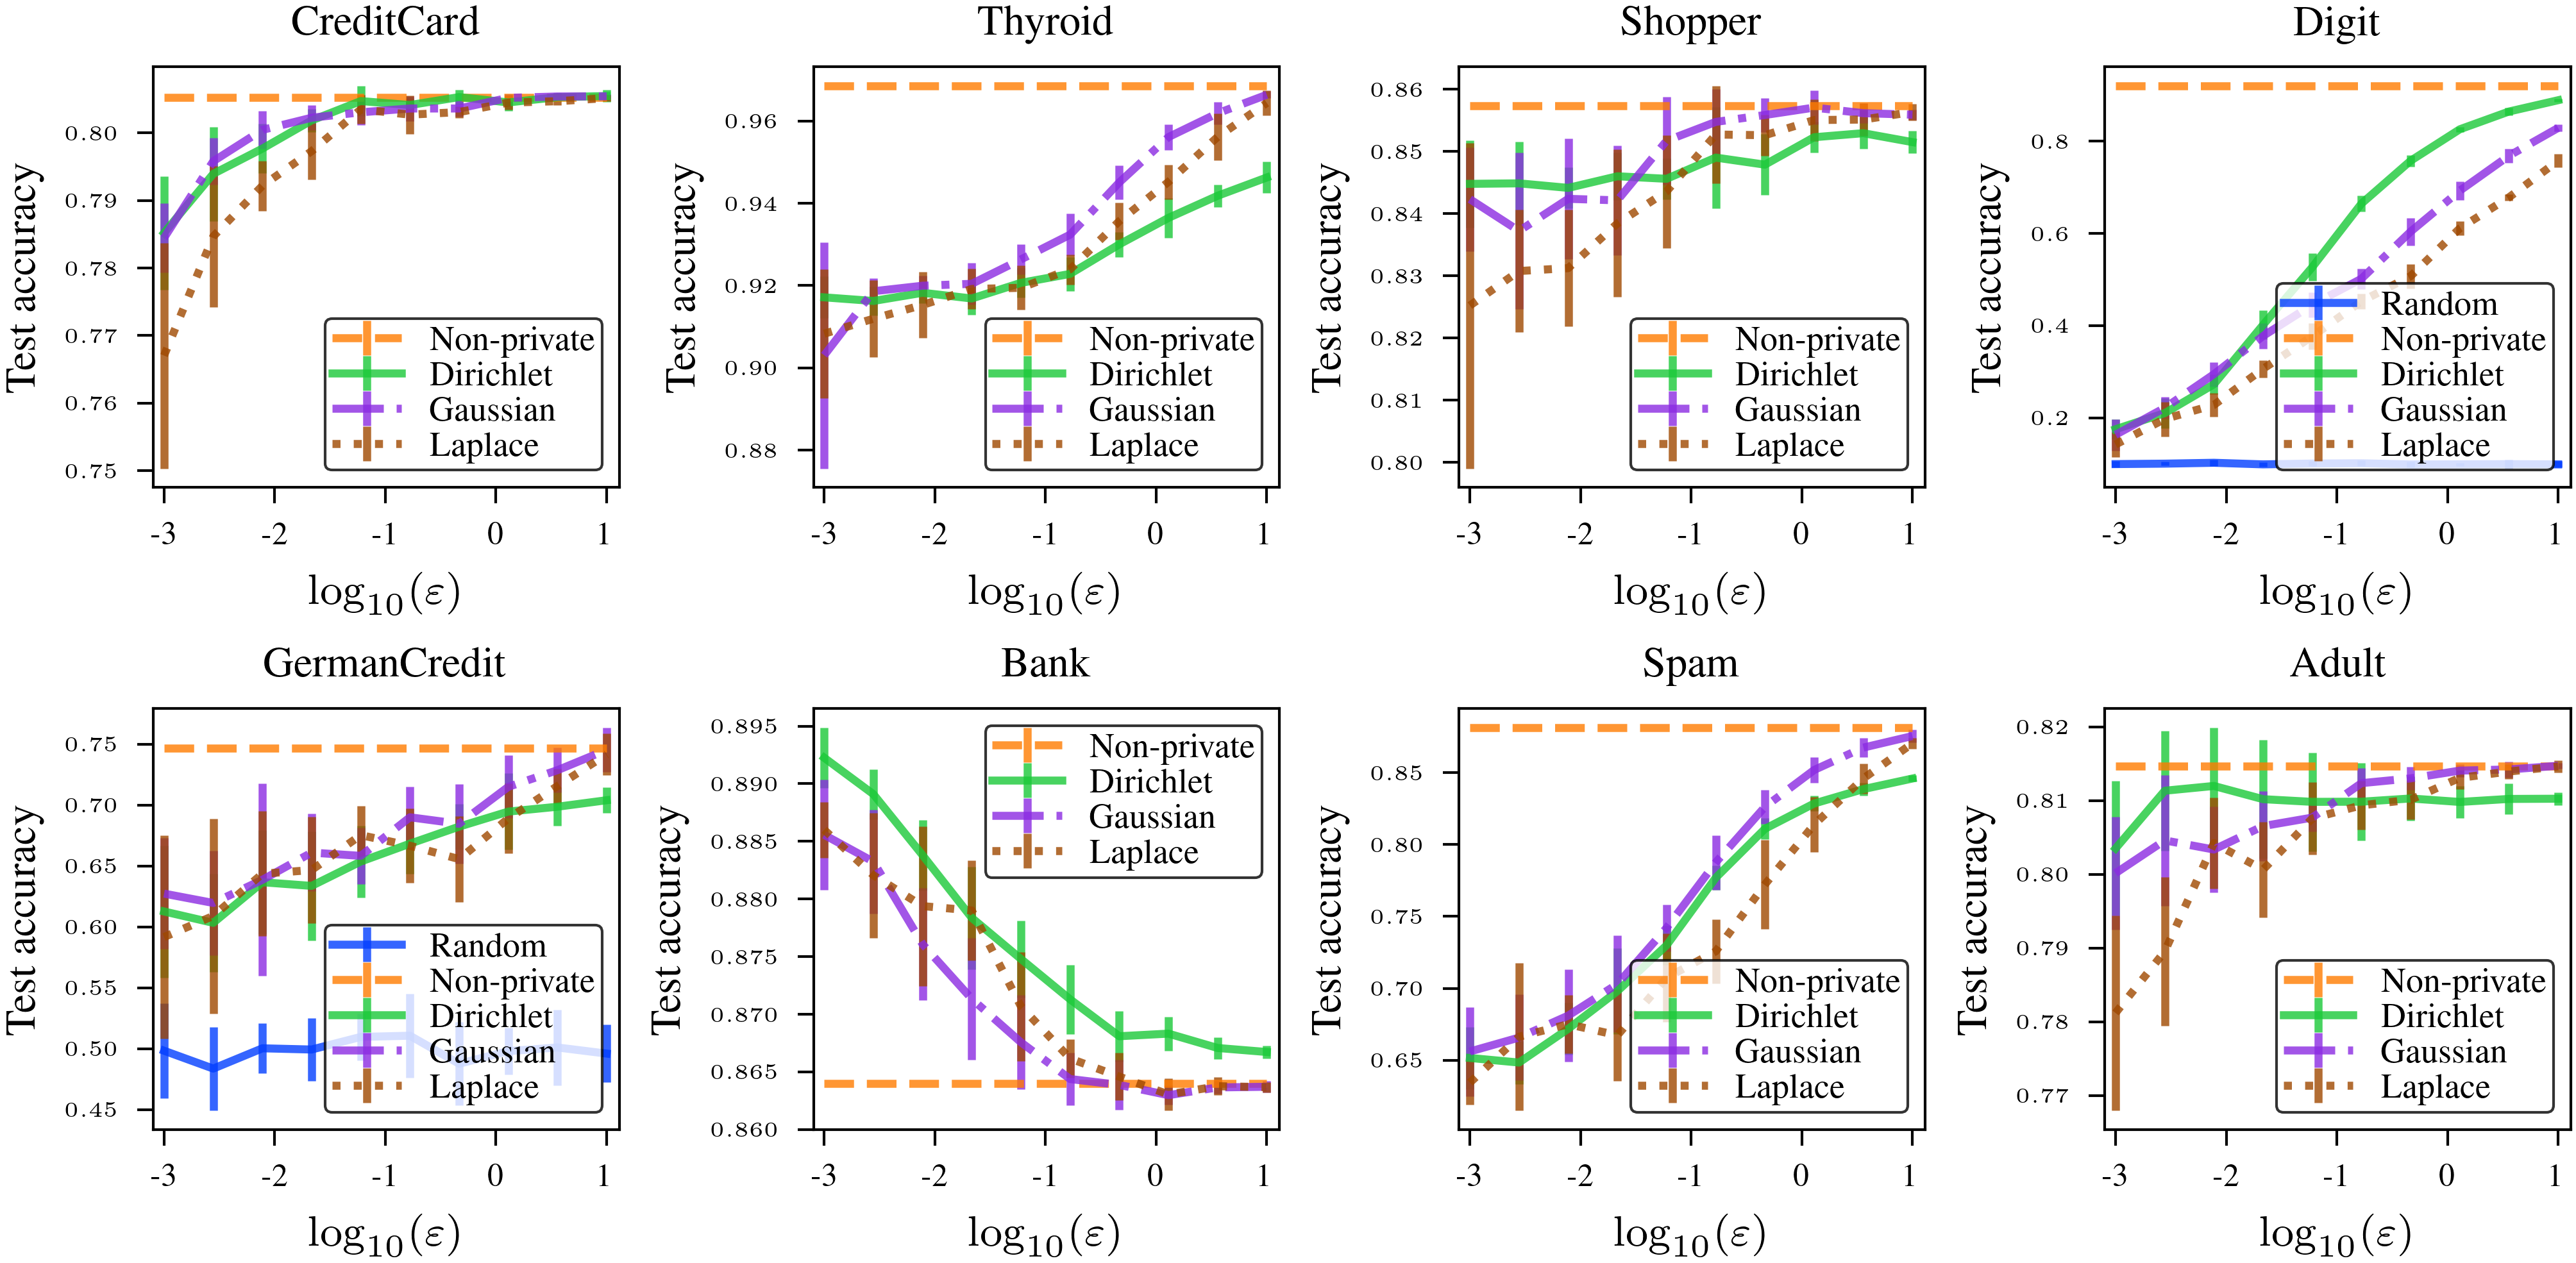

In [74]:
%matplotlib inline

plt.rcParams.update(figsizes.icml2022_full(nrows=1.6))
plt.rcParams.update(cycler.cycler(color=sns.color_palette("bright", 6)))

fig, axs = plt.subplots(nrows=2, ncols=4)
linestyles = ['-', '--', '-', '-.', ':']

for data, ax in zip(os.listdir('data'), axs.flatten()):
    if data in ['Digit.csv', 'GermanCredit.csv']:
        bars = [None]*len(model_list)
        model_list_ = model_list
        linestyles_ = linestyles
    else:
        bars = [None]*(len(model_list) - 1)
        ax._get_lines.get_next_color()
        model_list_ = model_list[1:]
        linestyles_ = linestyles[1:]

    for i, model in enumerate(model_list_):
        if i == len(model_list_)-2:
            ax._get_lines.get_next_color()
        bars[i] = ax.errorbar(eps_list,
                              results[data][model][1].mean(axis=1),
                              yerr=results[data][model][1].std(axis=1),
                              label=model,
                              lw=1.5,
                              ls=linestyles_[i],
                              alpha=0.8)
    ax.set_xlabel('$\\log_{10}(\\varepsilon)$')
    ax.set_xscale('log')
    ax.set_xlim(0.0008, 13)
    ax.set_xticks([0.001, 0.01, 0.1, 1, 10])
    ax.set_xticklabels([-3, -2, -1 , 0, 1])
    ax.set_ylabel('Test accuracy')
    if data[:-4] == 'Bank':
        loc = 'upper right'
    else:
        loc = 'lower right'
    ax.legend(bars,
              model_list_,
              loc=loc,
              borderpad=0.2,
              labelspacing=0.1)
    ax.tick_params(axis='y', which='major', labelsize=4)
    ax.set_title(data[:-4])

fig.tight_layout()
fig.savefig('naive_bayes_accuracy.pdf', bbox_inches='tight', format='pdf', dpi=1200)

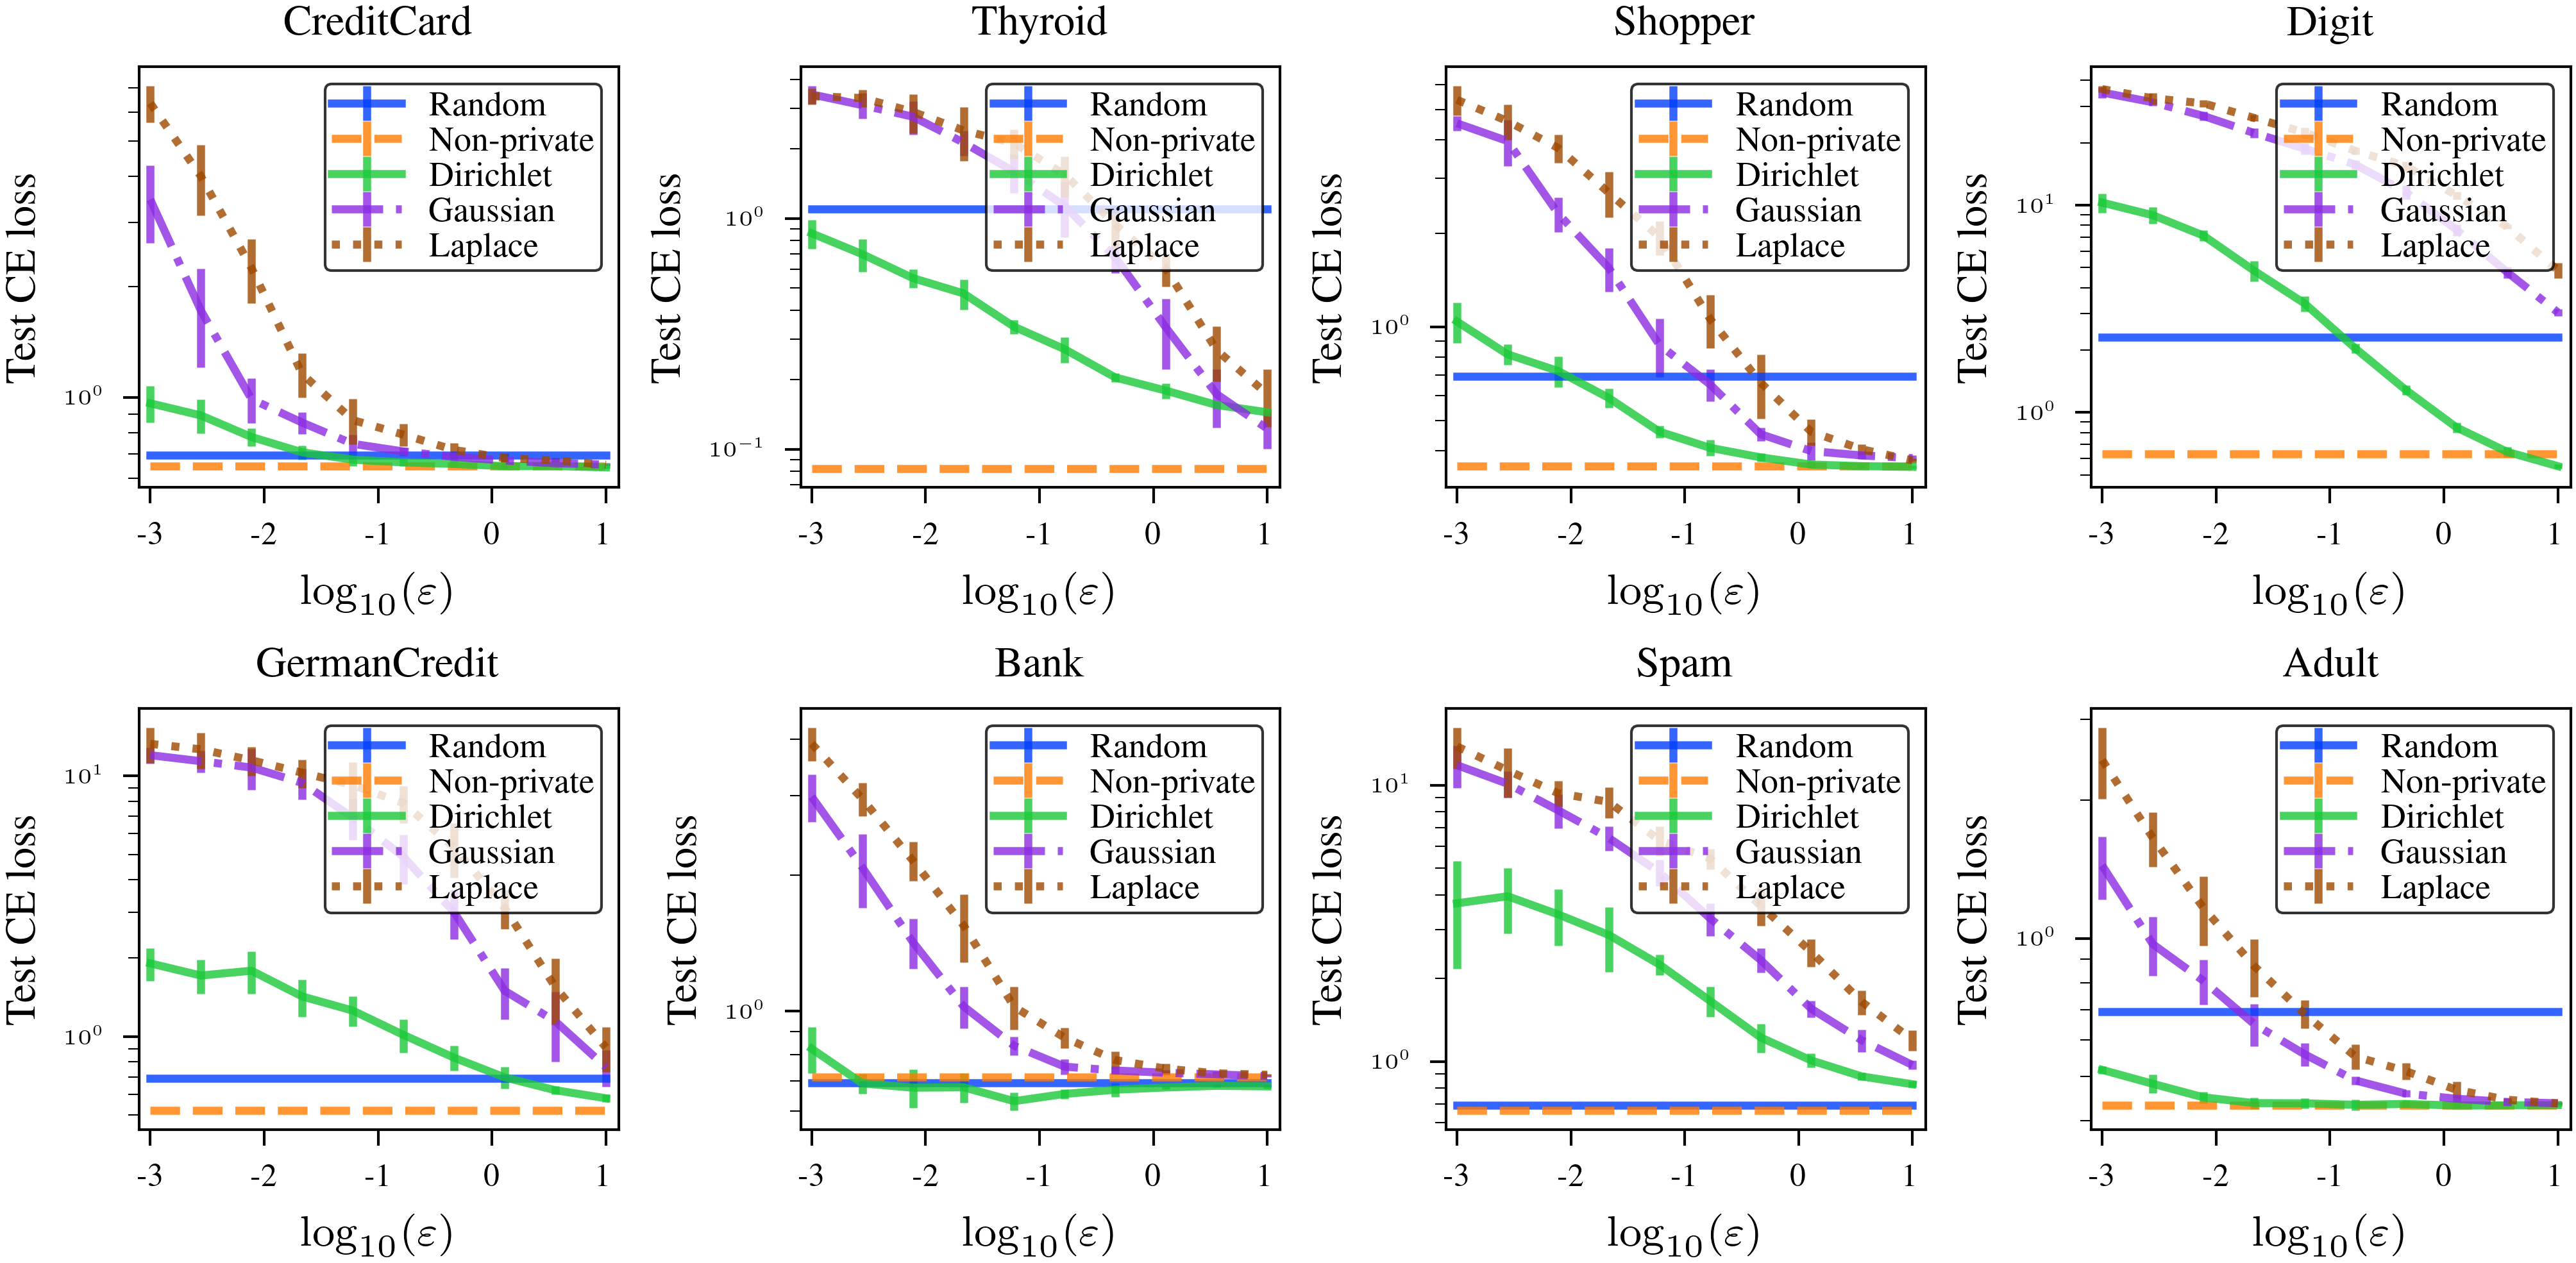

In [75]:
%matplotlib inline

from matplotlib.ticker import MultipleLocator

plt.rcParams.update(figsizes.icml2022_full(nrows=1.6))
plt.rcParams.update(cycler.cycler(color=sns.color_palette("bright", 6)))

fig, axs = plt.subplots(nrows=2, ncols=4)
bars = [None]*len(model_list)
linestyles = ['-', '--', '-', '-.', ':']

for data, ax in zip(os.listdir('data'), axs.flatten()):
    for i, model in enumerate(model_list):
        if i ==3:
            ax._get_lines.get_next_color()
        bars[i] = ax.errorbar(eps_list,
                              results[data][model][0].mean(axis=1),
                              yerr=results[data][model][0].std(axis=1),
                              label=model,
                              lw=1.5,
                              ls=linestyles[i],
                              alpha=0.8)
    ax.set_xlabel('$\\log_{10}(\\varepsilon)$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.0008, 13)
    ax.set_xticks([0.001, 0.01, 0.1, 1, 10])
    ax.set_xticklabels([-3, -2, -1 , 0, 1])
    ax.set_ylabel('Test CE loss')
    ax.legend(bars,
              model_list,
              loc='upper right',
              borderpad=0.2,
              labelspacing=0.1)
    ax.tick_params(axis='y', which='major', labelsize=4)
    ax.tick_params(axis='y', which='minor', labelleft=False)
    #ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
    ax.set_title(data[:-4])

fig.tight_layout()
fig.savefig('naive_bayes_crossentropy.pdf', bbox_inches='tight', format='pdf', dpi=1200)